In [114]:
import torch
import numpy
import matplotlib.pyplot as plt
from functools import partial
import graphviz
import utilities

def gv(s): return graphviz.Source('digraph G{ rankdir="LR"' + s + '; }')

In [137]:
# Define the URL and the local file path where the file will be saved
# Set the base path
file_name = "mnist_sample.tgz"
extract_path = "./mnist_sample"

path = utilities.untar_data(
  'https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz', 
  file_name, 
  extract_path
  )
path = (path/'mnist_sample')
Path.BASE_PATH = path

mnist_sample.tgz already exists. Skipping download.
./mnist_sample already exists. Skipping extraction.


In [138]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

seven_tensors = [torch.tensor(numpy.array(Image.open(o))) for o in sevens]
three_tensors = [torch.tensor(numpy.array(Image.open(o))) for o in threes]

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

## Stochastic Gradient Descent (SGD)

SGD is a simple yet powerful optimization algorithm used to train machine learning models.


**TLDR**; <br>
 In summary, following is the process of SGD.

1. **Stochastic**: Pick one data point (or a small batch) randomly from the dataset.
2. **Gradient**: Compute the gradient of the loss with respect to each parameter (weights and biases) for that data point.
3. **Learning Rate**: Multiply the gradient by the learning rate ($ \eta $) to control the step size.
4. **Update Parameters**: Adjust the parameters using:
   $$
   \text{New Parameter} = \text{Old Parameter} - \eta \cdot \text{Gradient}.
   $$
5. **Repeat**: Go back to Step 1 and repeat the process for the next data point (or mini-batch).
6. **Convergence**: Continue iterating until the loss stops decreasing significantly or a set number of iterations is reached.

In short: **Stochastic → Gradient → Learning Rate → Update → Repeat → Converge**.

**Easy to understand example:**<br><br>
You’re standing on a hilly landscape, and your goal is to find the lowest point (the valley). Each step you take moves you closer to the bottom.
- The gradient tells you which direction is downhill.
- The learning rate controls how big each step is.

Below we will learn each of these steps in more details. Just if you don't understand what's happening, come back and read the TLDR again.

---

Do you remember the way that Arthur Samuel described machine learning, which we quoted in <<chapter_intro>>?

> : Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.

As we discussed, this is the key to allowing us to have a model that can get better and better—that can learn. But our pixel similarity approach does not really do this. We do not have any kind of weight assignment, or any way of improving based on testing the effectiveness of a weight assignment. In other words, we can't really improve our pixel similarity approach by modifying a set of parameters. In order to take advantage of the power of deep learning, we will first have to represent our task in the way that Arthur Samuel described it.

Instead of trying to find the similarity between an image and an "ideal image," we could instead look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category. For instance, pixels toward the bottom right are not very likely to be activated for a 7, so they should have a low weight for a 7, but they are likely to be activated for an 8, so they should have a high weight for an 8. This can be represented as a function and set of weight values for each possible category—for instance the probability of being the number 8:

```
def pr_eight(x,w): return (x*w).sum()
```

Here we are assuming that `x` is the image, represented as a vector—in other words, with all of the rows stacked up end to end into a single long line. And we are assuming that the weights are a vector `w`. If we have this function, then we just need some way to update the weights to make them a little bit better. With such an approach, we can repeat that step a number of times, making the weights better and better, until they are as good as we can make them.

We want to find the specific values for the vector `w` that causes the result of our function to be high for those images that are actually 8s, and low for those images that are not. Searching for the best vector `w` is a way to search for the best function for recognising 8s. (Because we are not yet using a deep neural network, we are limited by what our function can actually do—we are going to fix that constraint later in this chapter.) 

To be more specific, here are the steps that we are going to require, to turn this function into a machine learning classifier:

1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

These seven steps, illustrated in <<gradient_descent>>, are the key to the training of all deep learning models. That deep learning turns out to rely entirely on these steps is extremely surprising and counterintuitive. It's amazing that this process can solve such complex problems. But, as you'll see, it really does!

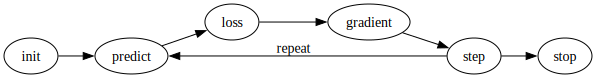

In [117]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

There are many different ways to do each of these seven steps.
These are the details that make a big difference for deep learning practitioners, but it turns out that the general approach to each one generally follows some basic principles. Here are a few guidelines:

- Initialize:: We initialize the parameters to random values. This may sound surprising. There are certainly other choices we could make, such as initializing them to the percentage of times that pixel is activated for that category—but since we already know that we have a routine to improve these weights, it turns out that just starting with random weights works perfectly well.
- Loss:: This is what Samuel referred to when he spoke of *testing the effectiveness of any current weight assignment in terms of actual performance*. We need some function that will return a number that is small if the performance of the model is good (the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention).
- Step:: A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, and a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating *gradients*. This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.
- Stop:: Once we've decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision. This is where that decision is applied. For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time.

### Calculating Gradients

The one magic step is the bit where we calculate the gradients. As we mentioned, we use calculus as a performance optimization; it allows us to more quickly calculate whether our loss will go up or down when we adjust our parameters up or down. In other words, the gradients will tell us how much we have to change each weight to make our model better.

You may remember from your high school calculus class that the *derivative* of a function tells you how much a change in its parameters will change its result. If not, don't worry, lots of us forget calculus once high school is behind us! But you will have to have some intuitive understanding of what a derivative is before you continue, so if this is all very fuzzy in your head, head over to Khan Academy and complete the [lessons on basic derivatives](https://www.khanacademy.org/math/differential-calculus/dc-diff-intro). You won't have to know how to calculate them yourselves, you just have to know what a derivative is.

The key point about a derivative is this: for any function, such as the quadratic function we saw in the previous section, we can calculate its derivative. The derivative is another function. It calculates the change, rather than the value. For instance, the derivative of the quadratic function at the value 3 tells us how rapidly the function changes at the value 3. More specifically, you may recall that gradient is defined as *rise/run*, that is, the change in the value of the function, divided by the change in the value of the parameter. When we know how our function will change, then we know what we need to do to make it smaller. This is the key to machine learning: having a way to change the parameters of a function to make it smaller. Calculus provides us with a computational shortcut, the derivative, which lets us directly calculate the gradients of our functions.

### Stepping With a Learning Rate

Deciding how to change our parameters based on the values of the gradients is an important part of the deep learning process. Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the **learning rate** (LR). The learning rate is often a number between 0.001 and 0.1, although it could be anything. Often, people select a learning rate just by trying a few, and finding which results in the best model after training (we'll show you a better approach later in this book, called the **learning rate finder**). Once you've picked a learning rate, you can adjust your parameters using this simple function:

```
w -= gradient(w) * lr
```

This is known as **stepping** your parameters, using an **optimizer step**. Notice how we _subtract_ the `gradient * lr` from the parameter to update it.  This allows us to adjust the parameter in the direction of the slope by increasing the parameter when the slope is negative and decreasing the parameter when the slope is positive.  We want to adjust our parameters in the direction of the slope because our goal in deep learning is to _minimize_ the loss.

Now it's time to look at an SGD example and see how finding a minimum can be used to train a model to fit data better.

Let's start with a simple, synthetic, example model. Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time. If you were measuring the speed manually every second for 20 seconds, it might look something like this:

In [118]:
def f(x): return (x**2).sum()

xt = torch.tensor([3., 4., 8., 10.]).requires_grad_()
f(xt)

tensor(189., grad_fn=<SumBackward0>)

Time: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])
Speed: tensor([74.4682, 59.6494, 45.8897, 26.3709, 21.4131, 19.4225, 12.5899, 10.7294,  3.7551, -0.8724, -0.2926,  3.4120,  4.9926, 10.3128, 15.4328, 26.2671, 31.7583, 42.0004, 57.5977, 66.8227])


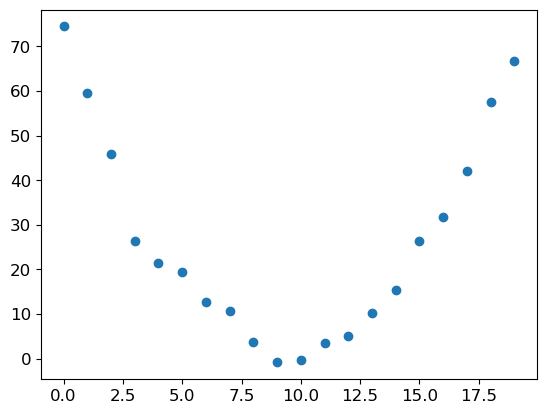

In [119]:
time = torch.arange(0,20).float()
print(f"Time: {time}")
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
print(f"Speed: {speed}")

plt.scatter(time, speed)

In [120]:
# We want to distinguish clearly between the function's input (the time when we are measuring the coaster's speed) 
# and its parameters (the values that define *which* quadratic we're trying).
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [121]:
# Step1: Initialize a random number
params = torch.randn(3).requires_grad_()
orig_params = params.clone()

In [122]:
# Step2: Calculate the predictions
preds = f(time, params)
print(f"Predictions: {preds}")

Predictions: tensor([ 1.3525e+00, -1.6391e-01, -3.2121e+00, -7.7919e+00, -1.3903e+01, -2.1547e+01, -3.0721e+01, -4.1428e+01, -5.3666e+01, -6.7436e+01, -8.2738e+01, -9.9571e+01, -1.1794e+02, -1.3783e+02,
        -1.5926e+02, -1.8222e+02, -2.0671e+02, -2.3274e+02, -2.6029e+02, -2.8938e+02], grad_fn=<AddBackward0>)


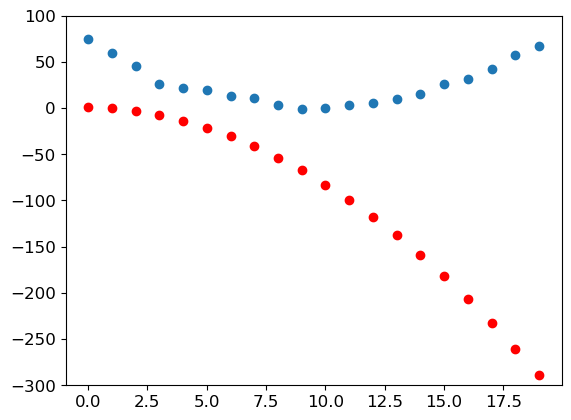

In [123]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    numpy_array = preds.detach().numpy()
    ax.scatter(time, speed)
    ax.scatter(time, numpy_array, color='red')
    ax.set_ylim(-300, 100)

show_preds(preds)

In [124]:
# Mean Squared Error
def mse(predictions, actuals): return ((predictions - actuals)**2).mean()

In [125]:
#Step3: Measure the loss
loss = mse(preds, speed)
print(f"MSE Loss: {loss}")

MSE Loss: 25823.80859375


In [126]:
# Calculate the gradient
loss.backward()

# Step 4: Pick a leaning rate, For now just a small number later we will learn how to pick the right learning rate
params.grad * 1e-5
print(f"Gradient: {params.grad}")
print(f"Updated Parameters: {params}")

Gradient: tensor([-53195.8633,  -3419.7148,   -253.8908])
Updated Parameters: tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)


In [127]:
# Update the parameters based on the calculated gradient
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [128]:
# Let's see if the loss improved
preds = f(time,params)
print(f"MSE Loss: {mse(preds, speed)}")

MSE Loss: 5435.53564453125


In [129]:
# repeat the process till the loss is minimized
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [130]:
# Iterate by looping many improvements
for i in range(10): apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023193359375
676.9645385742188
676.9537353515625


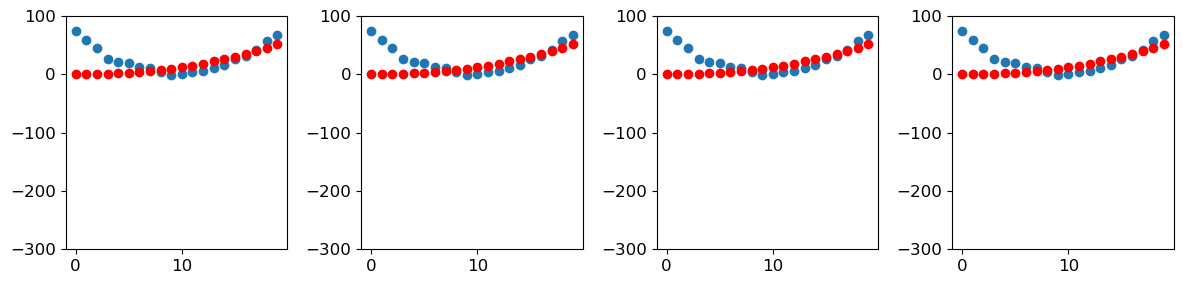

In [131]:
# we plot the function at every step. 
# Then we can see how the shape is approaching the best possible quadratic function for our data:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

To summarize, at the beginning, the weights of our model can be random (training *from scratch*) or come from a pretrained model (*transfer learning*). In the first case, the output we will get from our inputs won't have anything to do with what we want, and even in the second case, it's very likely the pretrained model won't be very good at the specific task we are targeting. So the model will need to *learn* better weights.

We begin by comparing the outputs the model gives us with our targets (we have labeled data, so we know what result the model should give) using a *loss function*, which returns a number that we want to make as low as possible by improving our weights. To do this, we take a few data items (such as images) from the training set and feed them to our model. We compare the corresponding targets using our loss function, and the score we get tells us how wrong our predictions were. We then change the weights a little bit to make it slightly better.

To find how to change the weights to make the loss a bit better, we use calculus to calculate the *gradients*. (Actually, we let PyTorch do it for us!) Let's consider an analogy. Imagine you are lost in the mountains with your car parked at the lowest point. To find your way back to it, you might wander in a random direction, but that probably wouldn't help much. Since you know your vehicle is at the lowest point, you would be better off going downhill. By always taking a step in the direction of the steepest downward slope, you should eventually arrive at your destination. We use the magnitude of the gradient (i.e., the steepness of the slope) to tell us how big a step to take; specifically, we multiply the gradient by a number we choose called the *learning rate* to decide on the step size. We then *iterate* until we have reached the lowest point, which will be our parking lot, then we can *stop*.

All of that we just saw can be transposed directly to the MNIST dataset, except for the loss function. Let's now see how we can define a good training objective. 

## The MNIST Loss function


### What Are We Trying to Achieve?

We are preparing data for training a machine learning model. Specifically:
1. **Input Data (`train_x`)**: These are the images of handwritten digits (3s and 7s). We need to convert these images into a format the model can understand.
2. **Labels (`train_y`)**: These are the "answers" or categories for each image. For example, we label all images of `3` as `1` and all images of `7` as `0`.

Once the data is prepared, we can use it to train a model that learns to distinguish between `3`s and `7`s.

### Step 1: Preparing the Input Data (`train_x`)

#### What Are the Images?
- Each image is a grid of pixels (e.g., 28x28 pixels for MNIST digits).
- In PyTorch, these images are stored as tensors (multi-dimensional arrays).

#### Why Change the Shape?
- A single image is a **matrix** (rank-2 tensor) of size `(28, 28)` (height x width).
- To feed these images into most machine learning models, we need to "flatten" them into **vectors** (rank-1 tensors) of size `(784,)` (since $ 28 \times 28 = 784 $).

#### How Do We Flatten Them?
- We use the `.view(-1, 28*28)` method:
  - `-1`: Automatically calculates how many rows are needed based on the data.
  - `28*28`: Flattens each image into a vector of length 784.

#### Combining All Images
- We have two groups of images: `stacked_threes` (all images of `3`) and `stacked_sevens` (all images of `7`).
- We combine them into one big tensor using `torch.cat()`.

#### Final Result:


In [132]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

- This creates a single tensor where:
  - Each **row** represents one flattened image (a vector of 784 pixels).
  - The total number of rows is the total number of images (`len(threes) + len(sevens)`).

### Step 2: Creating Labels (`train_y`)

#### What Are Labels?
- Labels tell the model what each image represents:
  - `1` means the image is a `3`.
  - `0` means the image is a `7`.

#### How Do We Create Labels?
- For all `3`s, we create a list of `1`s with the same length as the number of `3`s.
- For all `7`s, we create a list of `0`s with the same length as the number of `7`s.
- We concatenate these lists into one.

#### Adding an Extra Dimension
- Machine learning models often expect labels to be in a specific shape, like a column vector (rank-2 tensor with shape `(n, 1)`).
- We use `.unsqueeze(1)` to add an extra dimension to the labels tensor.

#### Final Result:

In [133]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)


- This creates a tensor where:
  - Each row corresponds to the label of one image.
  - The shape is `(n, 1)`, where `n` is the total number of images.

### Step 3: Prepare the data for PyTorch


A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

In [134]:
dataset = list(zip(train_x,train_y))
x,y = dataset[0]

x.shape,y

(torch.Size([784]), tensor([1]))

Also we need to prepare our validation sets the same way as training set.

In [136]:
valid_3_tens = torch.stack([torch.tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([torch.tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

FileNotFoundError: [Errno 2] No such file or directory: 'mnist_sample/valid/3'

In [135]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

NameError: name 'valid_3_tens' is not defined

Our dataset is now prepared for training, let's dive into the actual training steps.
As you may recall: 

__Init->Predict->Loss->Gradient->Step->(Repeat till we have low loss)->Stop__ 

---

## Start the training process

We'll be using **Logistic Regression** (a classification model). The purpose is to train the model to distinguish between two classes (3s and 7s) by learning a decision boundary using weights and bias. 

In a linear model, the prediction is calculated as: $y=w⋅x+b$

In neural networks, the `w` in the equation $y=w*x+b$ is called the *weights*, and the `b` is called the *bias*. Together, the weights and bias make up the *parameters*.

### 1. Init

Now we need an (initially random) weight for every pixel (this is the *initialize* step in our seven-step process):

In [ ]:
# initialize random weights for a model and prepares them for training:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

> We’re creating initial weights for a model, scaled appropriately, and ensuring they’re ready for gradient-based optimization.<br><br> 1. **`torch.randn(size)`**: Creates random numbers from a normal distribution (mean = 0, std = 1) with the given shape (`size`).<br>2. **`* std`**: Scales the random numbers to control their range (e.g., smaller `std` makes weights closer to 0).<br>3. **`.requires_grad_()`**: Tells PyTorch to track these weights so their gradients can be calculated during training.<br>

>**What Is std?** <br>
In short, std is to adjust the initial scale of the weights by making them larger or smaller at the start of training. This helps ensure the weights are in a good range for effective learning, but it doesn’t directly depend on the loss function.<br><br>
std stands for standard deviation , which controls the spread or scale of the random numbers. <br><br>
By multiplying the random numbers by std, we adjust their range. For example: <br><br>
If std = 1.0, the random numbers stay as-is (standard normal distribution). <br>
If std = 0.01, the random numbers are scaled down to be much smaller.

We create weights with size (28*28, 1) because:
- Each image is flattened into a vector of 784 pixels (features),
- We need one weight for each pixel to compute a weighted sum,
- The model produces a single output (e.g., a prediction for binary classification).

In [ ]:
weights = init_params((28*28,1))
weights[:5]

The function `weights*pixels` won't be flexible enough—it is always equal to 0 when the pixels are equal to 0 (i.e., its *intercept* is 0). You might remember from high school math that the formula for a line is `y=w*x+b`; we still need the `b`. We'll initialize it to a random number too:

This bias adds flexibility to the model by allowing it to shift predictions up or down, ensuring it can fit data even when inputs are zero. Like weights, the bias is updated during training to minimize the loss.

In [ ]:
bias = init_params(1)
bias

We can now calculate a prediction for one image:

In [ ]:
one_image = train_x[0]
weights_transpose = weights.T

one_image_predication = (one_image * weights_transpose).sum() + bias
one_image_predication

The `T` in `weights.T` stands for **transpose**. It’s a mathematical operation that flips the dimensions of a tensor or matrix. Let’s break this down step by step to explain what it does and why it’s used here.

> You can read more details about `.T` and how it works in Optional read notebook [.T Pytorch Transpose In Details](optional_read.ipynb#pytorch-transpose)

> If you are having hard time understanding what just happened here, read the simpler illustration in Optional reads Notebook [SGD Illustrate with code](optional_read.ipynb#sgd-illustrate-with-code)

Above example was just for one image in our dataset, now how do we do this for all the images to get prediction score? You might be thinking, we will loop through all the dataset and apply the function.
We could! However, that would be very slow. Because Python loops don't run on the GPU, and because Python is a slow language for loops in general, we need to represent as much of the computation in a model as possible using higher-level functions.

In this case, there's an extremely convenient mathematical operation that calculates `w*x` for every row of a matrix—it's called *matrix multiplication*.

In Python, matrix multiplication is represented with the `@` operator. Let's try it:

In [ ]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

> More details about this operation which is a __Linear Transformation and Matrix Multiplication__,  can be find [Linear Transformation: Matrix Multiplication](optional_read.ipynb#linear-transformation-matrix-multiplication)